## Реализован метод k-means,с помощью ООП.
Структура класса позаимствована из библиотеки sklearn.
### Параметры инициализации
<ul>
    <li>n_clusters</li>
    <li>select</li>
    <li>n_init</li>
    <li>max_iter</li>
    <li>random_state</li>
</ul>

### Атрибуты 

<ul>
    <li>centers_clusters</li>
    <li>inertia</li>
    <li>labels</li>
    </ul>
    
Большая часть параметров инициализации из scikit реализована.
Реализована эвристика для выбора начальных центры k-means++.
Есть три способа выбрать начальные центры <b>random</b>, <b>k-means++</b>, <b>массив центров</b>, передаваемый в n_clusters.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
class Kmeans:

    centers_clusters = None
    inertia = 0.0
    labels = None

    def __init__(
        self, n_clusters, select="k-means++", n_init=10, max_iter=300, random_state=None
    ):
        self.n_clusters = n_clusters
        self.select = select
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state

    def __calc_inertia(self, X):
        _inertia = 0.0
        for i in range(self.n_clusters):
            tmp = X[[j for j in range(X.shape[0]) if self.labels[j] == i], :].copy()
            if tmp.size != 0:
                _inertia += (
                    np.linalg.norm((tmp - self.centers_clusters[i]), axis=1) ** 2
                ).sum()
        return _inertia

    def __recalc_centers(self, X):
        centers = np.zeros(self.centers_clusters.shape, dtype="float64")
        for i in range(self.n_clusters):
            tmp = X[[j for j in range(X.shape[0]) if self.labels[j] == i], :].copy()
            if tmp.size != 0:
                centers[i] = np.array(tmp).mean(axis=0)
        return centers

    def __calc(self, X):
        _iter = 0
        while _iter <= self.max_iter:
            # не очень оптимально по памяти пользоваться трехмерными массивами,но затраты по
            # времени уменьшаются на 10%
            tmp = X.reshape(1, X.shape[0], -1)
            self.centers_clusters = self.centers_clusters.reshape(
                self.centers_clusters.shape[0], 1, -1
            )
            self.labels = np.linalg.norm((tmp - self.centers_clusters), axis=2).argmin(
                axis=0
            )
            self.centers_clusters = self.centers_clusters.reshape(
                self.centers_clusters.shape[0], -1
            )
            if np.absolute(self.centers_clusters - self.__recalc_centers(X)).sum() == 0:
                return self.__calc_inertia(X)
            else:
                self.centers_clusters = self.__recalc_centers(X)
            _iter += 1
        return self.__calc_inertia(X)

    def __selecting(self, X):
        if type(self.n_clusters) != int:
            self.centers_clusters = np.array(self.n_clusters)
            self.n_clusters = self.centers_clusters.shape[0]
        elif self.select == "random":
            self.centers_clusters = X[
                np.random.choice(X.shape[0], self.n_clusters, False), :
            ].copy()
        elif self.select == "k-means++":
            min_dist = np.zeros(X.shape[0], dtype="float64")
            self.centers_clusters = np.zeros((self.n_clusters, X.shape[1]))
            self.centers_clusters[0] = X[np.random.randint(0, X.shape[0])].copy()
            for i in range(1, self.n_clusters):
                for j in range(X.shape[0]):
                    min_dist[j] = np.linalg.norm(
                        (X[j] - self.centers_clusters[0:i, :]), axis=1
                    ).min()
                self.centers_clusters[i] = X[
                    np.random.choice(
                        X.shape[0], 1, p=(min_dist ** 2) / (min_dist ** 2).sum()
                    )
                ].copy()
        else:
            return None

    def calc(self, X):
        if self.random_state != None:
            np.random.seed(self.random_state)

        self.labels = np.zeros(X.shape[0], dtype="int")
        min_inertia = None
        for i in range(self.n_init):
            self.__selecting(X)
            tmp_label = self.labels.copy()
            tmp = self.__calc(X)
            if min_inertia == None or tmp < min_inertia:
                min_inertia = tmp
            else:
                self.labels = tmp_label
        self.inertia = min_inertia
        return self

    def predict(self, X):
        predict_labels = np.zeros(X.shape[0], dtype="int")
        tmp = X.reshape(1, X.shape[0], -1)
        self.centers_clusters = self.centers_clusters.reshape(
            self.centers_clusters.shape[0], 1, -1
        )
        self.predict_labels = np.linalg.norm(
            (tmp - self.centers_clusters), axis=2
        ).argmin(axis=0)
        self.centers_clusters = self.centers_clusters.reshape(
            self.centers_clusters.shape[0], -1
        )
        return predict_labels

<h3>Реализована матрица попарных расстояний.</h3>

Возвращает <b>отсортированную по меткам</b> матрицу размером NxN и отсотрированные метки выборки,
если параметр sorting_label=True.

In [3]:
def sorted_dist_matrix(X, labels, sorting_labels=False):
    sorted_X = np.concatenate([labels.reshape(-1, 1), X], axis=1)
    sorted_X = sorted_X[sorted_X[:, 0].argsort()]
    if sorting_labels:
        sorted_labels = sortes_X[:, 0:1]
    sorted_X = sorted_X[:, 1:]
    dist_matrix = np.zeros((X.shape[0], X.shape[0]), dtype="float64")
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            dist_matrix[i][j] = np.linalg.norm(sorted_X[i] - sorted_X[j])
    if sorting_labels:
        return dist_matrix, sorted_labels
    return dist_matrix

### Реализован метод выбора числа кластеров - метод силуэтов.

Он немного неоптимально написан, времени не хватило.

In [4]:
def silhouette(X, labels):
    def __calc_ai(X, labels, i):
        a_i = 0
        size = 0
        for j in range(X.shape[0]):
            if labels[j] == labels[i]:
                size += 1
                a_i += np.linalg.norm(X[j] - X[i])
        if size > 1:
            return a_i / (size - 1)
        return 0

    def __calc_bi(X, labels, i):
        min_b_i = None
        size = 0
        unique = np.unique(labels)
        if unique.size <= 1:
            return 0
        for j in unique:
            if j == labels[i]:
                continue
            b_i = 0
            tmp_size = 0
            for t in range(X.shape[0]):
                if j == labels[t]:
                    tmp_size += 1
                    b_i += np.linalg.norm(X[t] - X[i])
            if (min_b_i is None) or min_b_i > b_i:
                min_b_i = b_i
                size = tmp_size
        return min_b_i / size

    S = 0
    for i in range(X.shape[0]):
        a_i = __calc_ai(X, labels, i)
        b_i = __calc_bi(X, labels, i)

        if a_i != 0 and b_i != 0:
            S += (b_i - a_i) / max(a_i, b_i)
    return S / X.shape[0]

<h2>Демонстрация написанных алгоритмов</h2>



In [5]:
from sklearn import datasets

a = [[1, 1], [2, 1.5], [3, 1]]
X, y = datasets.samples_generator.make_blobs(
    81, centers=a, n_features=2, cluster_std=0.15, center_box=(-0.5, 0.5)
)
N = len(a)

# Примеры инициализации Kmeans

In [6]:
K_r = Kmeans(n_clusters=N, select="random", n_init=10, max_iter=300, random_state=True)
K_r.calc(X)
K_r.inertia

3.996797892723297

In [7]:
K_p = Kmeans(n_clusters=N, select="k-means++", n_init=10, max_iter=300)
K_p.calc(X)
K_p.inertia

3.996797892723297

#### Демонстрация того, что целевые функции в моем алгоритме и алгоритме k-means из библиотеки sklearn практически равны
$$\sum_{i=1}^{k}\sum_{x\in C_i}(x-\alpha_i)^2 -\textrm{целевая функция}$$

In [8]:
from sklearn import cluster

K_sci = cluster.KMeans(n_clusters=N, init="k-means++", n_init=10, max_iter=300).fit(X)
K_sci.inertia_

3.996797892723297

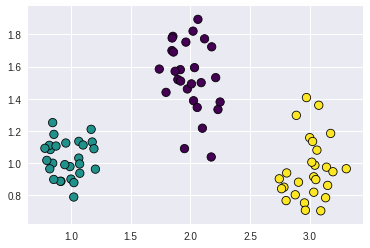

In [9]:
plt.figure(figsize=(6, 4))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=K_p.labels,
    s=70,
    edgecolors="black",
    linewidth=0.8,
    cmap="viridis",
)

### На "хорошиx" данных отсортированная матрица попарных расстояний очень наглядна

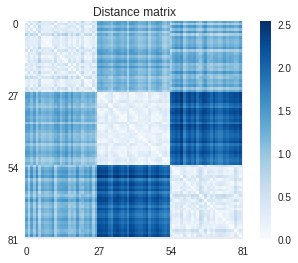

In [10]:
plt.grid(b=False)
plt.imshow(sorted_dist_matrix(X, K_p.labels), cmap="Blues")
plt.colorbar()
plt.title("Distance matrix")
plt.xticks(np.arange(0, X.shape[0] + 1, X.shape[0] / N))
plt.yticks(np.arange(0, X.shape[0] + 1, X.shape[0] / N))
plt.show()

### Метод Силуэтов
По оси Y - мера качества кластеризации с точки зрения количества кластеров, по оси X - количество кластеров

#### Нахождение оптимальное число кластеров
Конечно, для решения этой задачи сразу приходит в голову искать то количество кластеров, которое минимизирует целевую функцию(конечно до определенного значения, когда изменение целевой функции мало). Как раз в этом состоит метод локтя. Я решил его не делать, потому что он довольно субъективный, а сделал метод силуэтов, который точно может сказать лучее количество кластеров

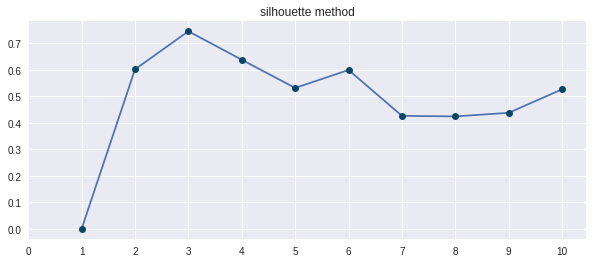

In [11]:
x = []
y = []
k = 10
for i in range(1, k + 1):
    K = Kmeans(n_clusters=i, select="k-means++", n_init=10, max_iter=300)
    K.calc(X)
    x.append(i)
    y.append(silhouette(X, K.labels))
plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.plot(x, y, "o", color="#0a4766")
plt.title("silhouette method")
plt.xticks(np.arange(0, k + 1, 1.0))
plt.show()